## Importing libs

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

## Neural Network

Being $m$ the number of samples in a batch, from a layer $k-1$ to a layer $k$ we have:
- Weights $\mathbb{W}^{(k)} \in \mathbb{R}^{n_{k-1} \times n_k}$
- Biases $\mathbf{b}^{(k)} \in \mathbb{R}^{n_k}$
- Activations $\mathbb{A}^{(k)} = g_k(\mathbb{Z}^{(k)}) \in \mathbb{R}^{m \times n_k}$, where $g_k(\mathbb{Z}^{(k)})$ is the activation function of the $k^{\text{th}}$ layer and $\mathbb{Z}^{(k)} = \mathbb{A}^{(k-1)} \mathbb{W}^{(k)} + \mathbf{b}^{(k)}$

(Xavier initialization: [[1]](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/))

For the first layer, the activation is the input itself: $\mathbb{A}^{(1)} = \mathbb{X} \in \mathbb{R}^{m \times n_1}$, where $n_1$ is the input size (3072)  
For the middle layers ($2 \leq k < L$), the activation function is the sigmoid: $\mathbb{A}^{(k)} = g_k(\mathbb{Z}^{(k)}) = sigmoid(\mathbb{Z}^{(k)})$  
For the last layer, we have the predicted value with softmax activation: $\mathbb{A}^{(L)} = g_k(\mathbb{Z}^{(L)}) = softmax(\mathbb{Z}^{(L)}) \in \mathbb{R}^{m \times n_L}$, where $n_L$ is the output size (10)  
(i.e. the hypothesis function $a^{(L)} = h_{W, b}(x) = y_{\text{pred}} \approx y$)

obs.: the number of layers $L$ comes from: $1$ input layer + $1$ output layer + $L-2$ hidden layers

In [3]:
import warnings

# RANDOM_SEED = 886

In [4]:
class ActivationFunction:
    ''' An ActivationFunction is applied to Z to get the output A, 
        but its derivative expects the value A, not Z (!):

        A == __call__(Z) and derivative(A) == derivative(__call__(Z)), 
        calling derivative(Z) will often yield WRONG results
    '''
    def __call__(self, Z):
        ''' Z.shape=(n_examples, layer_output_size) '''
        raise NotImplementedError    
    def derivative(self, A):
        ''' A.shape=(n_examples, layer_output_size) '''
        raise NotImplementedError

class Linear(ActivationFunction):
    def __call__(self, Z):
        return Z
    def derivative(self, A):
        return np.ones_like(A)

class Sigmoid(ActivationFunction):
    def __call__(self, Z):
        return 1 / (1 + np.exp(-Z))
    def derivative(self, A):
        return A * (1 - A) # Sigmoid(Z) * (1 - Sigmoid(Z))

class ReLU(ActivationFunction):
    def __call__(self, Z):
        return np.maximum(0, Z)
    def derivative(self, A):
        return np.where(A > 0, 1, 0)

class SoftMax(ActivationFunction):
    def __call__(self, Z):
        exp = np.exp(Z - Z.max(axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)
    def derivative(self, A):
        return A * (1 - A) # SoftMax(Z) * (1 - SoftMax(Z))
    
        #S = A.reshape(-1, m)
        #return np.diagflat(S) - np.dot(S, S.T)

obs.: $\mathbf{e}^{x+c}$ / sum($\mathbf{e}^{x+c}$) == ($\mathbf{e}^x$ * $\mathbf{e}^c$) / ($\mathbf{e}^c$ * sum($\mathbf{e}^x$)) == $\mathbf{e}^x$ / sum($\mathbf{e}^x$)

In [5]:
class CostFunction:
    ''' A CostFunction is applied to Y (the target values) and Ypred to get a scalar output
        Its derivative w.r.t. Ypred also expects Y and Ypred, but returns tensor (n_examples, last_layer_output_size)
        
        obs.: Ypred is the last layer's activation values: last_layer.A == last_layer.g(last.layer.Z)
    '''
    def __call__(self, Y, Ypred):
        ''' Y.shape == Ypred.shape == (n_examples, last_layer_output_size) '''
        raise NotImplementedError # [J(Y, Ypred)]
    def derivative(self, Y, Ypred):
        ''' Y.shape == Ypred.shape == (n_examples, last_layer_output_size) '''
        raise NotImplementedError # [dJ/dYpred]

class CrossEntropy(CostFunction):
    def __call__(self, Y, Ypred):
        return np.mean( -(Y * np.log(Ypred)).sum(axis=1) ) ## == - (1/m) * (Y * np.log(Ypred)).sum(axis=(0, 1))
    def derivative(self, Y, Ypred):
        m = Ypred.shape[0]
        return - (Y / Ypred) / m

obs.:

---
```python
CrossEntropy.derivative(Y, Ypred) * SoftMax.derivative(Ypred) ==  
      - (1/m) * (Y / Ypred)       *    Ypred * (1 - Ypred)    == - (1/m) * Y * (1 - Ypred)  
                                                              == - (1/m) * (Y - Y*Ypred)  
                                                              == (Y*Ypred - Y) / m```
---  


In [6]:
# FIXME return (Ypred - Y) / m

In [7]:
class Optimizer:
    ''' The optimizer's optimization policy should be implemented on its update(layers) function '''
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    def update(self, layers):
        ''' Updates the parameters (i.e. weights and biases) for each layer in the layers list '''
        raise NotImplementedError

class GradientDescent(Optimizer):
    def __init__(self, learning_rate):
        super().__init__(learning_rate)
    def update(self, layers):
        for layer in layers[1:]:
            layer.W -= self.learning_rate * layer.dW
            layer.b -= self.learning_rate * layer.db   

In [8]:
class Layer:
    ''' A.shape == (n_examples, output_size)
        Z.shape == (n_examples, output_size)
        W.shape == (input_size, output_size)
        b.shape == (output_size, )
        obs.:
            input_size == prev_layer.output_size
            output_size == next_layer.input_size
    '''
    def __init__(self, output_size, activation_function):
        if activation_function != None:
            assert(isinstance(activation_function, ActivationFunction)), "Invalid object type for activation_function"
        else:
            warnings.warn("\nThe activation_function isn't set for this layer (this is only ok if it is the input layer)")
        
        self.input_size = None
        self.output_size = output_size
        
        # activation function
        self.g = activation_function # g_prime == activation_function.derivative
        
        # activation values
        self.A = None # self.A == self.g(self.Z)
        self.Z = None # prev_layer.A @ self.W + self.b
        
        # output value of the previous layer
        self.X = None # == prev_layer.A
        
        # parameters (weights and biases)
        self.W = None
        self.b = None
        self.dW = None
        self.db = None
    
    def init(self, input_size, weight_initialization):
        ''' Sets the layer's input_size and initializes its weights and biases '''
        self.input_size = input_size
        if weight_initialization == 'xavier':
            stddev = np.sqrt(1 / self.input_size)
            self.W = stddev * np.random.randn(self.input_size, self.output_size)
            self.b = np.random.randn(self.output_size, )
        elif weight_initialization == 'xavier_avg':
            stddev = np.sqrt(2 / (self.input_size + self.output_size))
            self.W = stddev * np.random.randn(self.input_size, self.output_size)
            self.b = np.random.randn(self.output_size, )
        elif weight_initialization == 'rand_-1_to_1':
            self.W = 2 * np.random.randn(self.input_size, self.output_size) - 1
            self.b = 2 * np.random.randn(self.output_size, ) - 1
        else:
            raise ValueError(f"Invalid weight_initialization value: '{weight_initialization}'")
    
    @property
    def params_count(self):
        return self.W.size + self.b.size
    
    # receives the activation values of the previous layer (i.e. this layer's input)
    # returns the activation values of the current layer (i.e. next layer's input)
    def feedforward(self, X):
        ''' X.shape == (n_examples, self.input_size) '''
        assert(X.shape[1] == self.input_size)
        self.X = X
        # (n_examples, output_size) = (n_examples, input_size) @ (input_size, output_size) + (output_size, )
        self.Z = self.X @ self.W + self.b
        self.A = self.g(self.Z)
        return self.A
    
    # receives the derivative of the cost function w.r.t. the activation values of the current layer (i.e. next layer's input)
    # returns the derivative of the cost function w.r.t. the activation values of the previous layer (i.e. this layer's input)
    def backprop(self, dA):
        ''' dA.shape == (n_examples, self.output_size)
        
            Note that only calling backprop doesn't actually update the layer parameters
        '''
        assert(dA.shape[1] == self.output_size)        
        # (n_examples, output_size) = (n_examples, output_size) * (n_examples, output_size)
        # (input_size, output_size) = (input_size, n_examples)  @ (n_examples, output_size)
        # (output_size, )           = (n_examples, output_size).sum(axis=0)
        # (n_examples, input_size)  = (n_examples, output_size) @ (output_size, input_size), input_size==prev_layer.output_size
        delta = dA * self.g.derivative(self.Z) # [dJ/dZ = dJ/dA . dA/dZ]
        self.dW = (self.X).T @ delta           # [dJ/dW = dJ/dZ . dZ/dX]
        self.db = delta.sum(axis=0)            # [dJ/db = dJ/dZ . dZ/db]
        return delta @ (self.W).T              # [dJ/dX = dJ/dZ . dZ/dX], note that dJ/dX is dA for the previous layer

In [28]:
class NN:
    def __init__(self, layers, cost_function, optimizer, weight_initialization='xavier'):
        assert(isinstance(cost_function, CostFunction)), "Invalid object type for cost_function"
        
        self.J = cost_function # cost_function(Y, Ypred)
        # obs.: cost_function.derivative is the derivative of J w.r.t. the last layer's activation values [dJ/dYpred]
        #       Ypred == self.layers[-1].A, thus self.J.derivative is the input (dA) for the last layer's backprop
        
        self.optimizer = optimizer # obs.: the learning rate is set on the optimizer object
        
        self.layers = []
        self.layers.append(layers[0]) # input layer (we don't init it since we set it's activation values manually)
        for l in range(1, len(layers)):            
            # sets the layer's input_size as the last layer's output_size and initializes its weights and biases
            layers[l].init(input_size=layers[l-1].output_size, weight_initialization=weight_initialization)            
            self.layers.append(layers[l]) # adds the initialized layer to the network
        
        self.history = { "loss": [], "loss_val": [], "acc": [], "acc_val": [] }
    
    # note that we use zero-based indexing here, so
    # the 1st layer is self.layers[0] and the last is self.layers[len(self.layers) - 1]
    
    def predict(self, X):
        ''' X.shape == (n_examples, self.layers[0].input_size) '''
        assert(X.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        activation = X # network's input
        for l in range(1, len(self.layers)):
            Z = activation @ self.layers[l].W + self.layers[l].b
            activation = self.layers[l].g(Z)
        return activation # network's output (Ypred)
    
    def feedforward(self, X):
        ''' X.shape     == (n_examples, self.layers[0].input_size)
            Ypred.shape == (n_examples, self.layers[-1].output_size)
        '''
        assert(X.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        self.layers[0].A = X # input
        for l in range(1, len(self.layers)):
            self.layers[l].feedforward(self.layers[l-1].A)
        Ypred = self.layers[-1].A # output
        return Ypred
    
    def backprop(self, X, Y, Ypred):
        ''' X.shape     == (n_examples, self.layers[0].input_size)
            Y.shape     == (n_examples, self.layers[-1].output_size)
            Ypred.shape == (n_examples, self.layers[-1].output_size)
            where Ypred is the result of feedforward(X)
            
            Note that only calling backprop doesn't actually update the network parameters
        '''
        assert(X.shape[0] == Y.shape[0])
        assert(X.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        assert(Y.shape[1] == self.layers[-1].output_size)
        
        cost_wrt_Ypred = self.J.derivative(Y, Ypred) # [dJ/dYpred]
        dA = self.layers[-1].backprop(cost_wrt_Ypred)
        for l in reversed(range(1, len(self.layers) - 1)): # we don't do backprop on the input layer
            dA = self.layers[l].backprop(dA)
    
    def __shuffle_X_Y(self, X, Y):
        m = X.shape[0] # == Y.shape[0]
        p = np.random.permutation(m)
        return X[p], Y[p]
    
    def __get_batches(self, X, Y, batch_size, shuffled):
        m = X.shape[0] # == Y.shape[0]
        n_batches = m // batch_size
        if shuffled:
            X, Y = self.__shuffle_X_Y(X, Y)
        for i in range(n_batches):
            yield (X[batch_size*i : batch_size*(i+1)], 
                   Y[batch_size*i : batch_size*(i+1)])
        return
    
    # trainning and validation data
    def train(self, X, Y, X_val, Y_val, n_epochs, batch_size, verbose=True):
        ''' X.shape == (n_training_samples, self.layers[0].input_size)
            Y.shape == (n_training_samples, self.layers[-1].output_size)
            
            X_val.shape == (n_validation_samples, self.layers[0].input_size)
            Y_val.shape == (n_validation_samples, self.layers[-1].output_size)
            
            For each iteration we'll have:
              n_examples = batch_size
              batch_X.shape == (n_examples, self.layers[0].input_size)
              batch_Y.shape == (n_examples, self.layers[-1].output_size)
            Thus, each epoch has ceil(n_training_samples / batch_size) iterations
            obs.: batch_X and batch_Y are rows of X and Y, and after each iteration (i.e. after going through
                  each batch) we update our network parameters (weights and biases)
            
            If n_training_samples is not divisible by batch_size the last training batch will be smaller
        '''
        assert(X.shape[0] == Y.shape[0])
        assert(X.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        assert(Y.shape[1] == self.layers[-1].output_size)
        assert(X_val.shape[0] == Y_val.shape[0])
        assert(X_val.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        assert(Y_val.shape[1] == self.layers[-1].output_size)
        
        n_training_samples = X.shape[0]
        batches_per_epoch = int(np.ceil(n_training_samples / batch_size)) # same as the number of iterations per epoch
        
        for epoch in range(n_epochs):
            batch_number = 0
            for batch_X, batch_Y in self.__get_batches(X, Y, batch_size, shuffled=True):
                # calculates the predicted target values for this batch (with the current network parameters)
                batch_Ypred = self.feedforward(batch_X)
                
                # sets the values of dW and db, used to then update the network parameters
                self.backprop(batch_X, batch_Y, batch_Ypred)
                
                # updates each layer's parameters (i.e. weights and biases) with gradient descent
                self.optimizer.update(self.layers)
                
                    batch_number += 1
                if verbose and ((batches_per_epoch/10) % batch_number == 0):
                    print(f"batch ({batch_number}/{batches_per_epoch})", end='\r')
            
            # calculate the loss/cost value for this epoch
            epoch_cost, epoch_accuracy = evaluate(X, Y) # training set
            epoch_cost_val, epoch_accuracy_val = evaluate(X_val, Y_val) # validation set
            self.history["loss"].append(epoch_cost)
            self.history["loss_val"].append(epoch_cost_val)
            self.history["acc"].append(epoch_accuracy)
            self.history["acc_val"].append(epoch_accuracy_val)
            if verbose:
                print(f"epoch ({epoch+1}/{n_epochs}) "
                      f"loss: {epoch_cost:.4f}, loss_val: {epoch_cost_val:.4f} | "
                      f"acc: {epoch_accuracy:.2f}, acc_val: {epoch_accuracy_val:.2f}")
    
    # test data
    def evaluate(self, X_test, Y_test):
        ''' X_test.shape == (n_test_samples, self.layers[0].input_size)
            Y_test.shape == (n_test_samples, self.layers[-1].output_size)
        '''
        assert(X_test.shape[0] == Y_test.shape[0])
        assert(X_test.shape[1] == self.layers[0].output_size) # self.layers[0].input_size == self.layers[0].output_size
        assert(Y_test.shape[1] == self.layers[-1].output_size)
        
        # loss/cost value for the training set
        Ypred = self.feedforward(X_test)
        cost = self.J(Y_test, Ypred)
        
        # calculates the values not as one-hot encoded row vectors
        target = np.argmax(Y_test, axis=1)
        prediction = np.argmax(Ypred, axis=1)
        accuracy = (prediction == target).mean()        
        
        return cost, accuracy

## Logistic Regression

### Get the data sets

**NOTE:** you should have the .npz files in the following directory

In [10]:
# confirm that you have test.npz, train.npz and val.npz
!ls ../mini_cinic10/

classes_and_names.csv
images
README.txt
test.npz
train.npz
val.npz


In [11]:
PATH_TO_DATA = os.path.join("..", "mini_cinic10")

train_data = np.load(os.path.join(PATH_TO_DATA, "train.npz"))
val_data   = np.load(os.path.join(PATH_TO_DATA, "val.npz"))
# test_data  = np.load(os.path.join(PATH_TO_DATA, "test.npz")) # assume this doesn't exist

In [12]:
xs, ys = train_data['xs'], train_data['ys']
print(xs.shape, xs.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print(ys.shape, ys.dtype)

(80000, 3072) uint8
(80000,) uint8


In [13]:
xs_val, ys_val = val_data['xs'], val_data['ys']
print(xs_val.shape, xs_val.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print(ys_val.shape, ys_val.dtype)

(10000, 3072) uint8
(10000,) uint8


In [14]:
IMG_WIDTH = IMG_HEIGHT = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # RGB images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH*3, )

# classes_and_names.csv
CLASS_NAME = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
CLASS_COUNT = len(CLASS_NAME)

In [15]:
def unflatten(flat_img, img_shape=IMG_SHAPE):
    ''' Converts a flattened image back into a 3-layer RGB matrix representation '''
    return flat_img.reshape(img_shape)

In [16]:
def show_image(img_index, xs, ys, figsize=None):
    ''' Shows the image represented by the img_index-th row of xs '''
    if figsize != None:
        fig = plt.figure(figsize=figsize)
    plt.imshow(unflatten(xs[img_index]))
    plt.title(f'idx #{img_index} ({CLASS_NAME[ys[img_index]]})')
    plt.axis(False)
    plt.show()

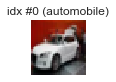

In [17]:
show_image(0, xs, ys, [1, 1])

## Normalize xs and one-hot encode ys

In [18]:
print(f"xs: mean={xs.mean():>8.4f}, stddev={xs.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs.mean(), xs.std()
X = (xs - mean) / std

print(f"X:  mean={X.mean():>8.4f}, stddev={X.std():>7.4f}")

xs: mean=117.3316, stddev=63.1088
X:  mean=  0.0000, stddev= 1.0000


In [19]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=118.1221, stddev=63.2348
X_val:  mean=  0.0125, stddev= 1.0020


In [20]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [21]:
def peek_compare(ys, Y, n_rows=5):
    ''' Y == onehot_encode(ys) '''
    return np.append(ys[:n_rows].reshape((-1, 1)), Y[:n_rows], axis=1)

In [22]:
Y = onehot_encode(ys)
print(ys.shape, Y.shape)

(80000,) (80000, 10)


In [23]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(10000,) (10000, 10)


### Train the network

In [29]:
nn_log_reg = NN(
    cost_function=CrossEntropy(),
    optimizer=GradientDescent(learning_rate=1e-4),
    weight_initialization='xavier',
    layers=[
        Layer(3072, None), Layer(10, SoftMax())
    ])

d:\documents\github\unicamp\lib\site-packages\ipykernel_launcher.py:14: UserWarning: 
The activation_function isn't set for this layer (this is only ok if it is the input layer)
  


In [30]:
nn_log_reg.train(
    X, Y,
    X_val, Y_val,
    n_epochs=2,
    batch_size=1250
) # X, Y, X_val, Y_val, n_epochs, batch_size, verbose=True

ZeroDivisionError: float modulo

In [27]:
for layer in nn_log_reg.layers:
    print(layer.input_size)
    print(layer.output_size)
    print(layer.g)

None
3072
None
3072
10
